# The Empire's Greatest Threat: Medical Appointment No Shows

## Business Applications
The Empire is facing a serious problem with Stormtroopers & Officers not turning up for scheduled medical appointments. On top of wasting time and resources, this hinders other Stormtroopers from being able to schedule needed appointments at the same time.  We have been tasked to come up with a logistic regression model that can be used to predict whether a person will make their appointment and is more accurate than the Force. Failure to do so will incur the wrath of the Emperor.

## Research Questions
* Number of appointments per day
* Number of troopers with pre existing conditions (% of pop)
* Average number of appointments made at different times throughout the day
* Investigate the relationship between neighbourhood and no-show
* Age, gender and pre existing conditions summary
* Examining relationship with neighbourhood, and pre existing condition/age/no show
* A logistic regression model that predicts how likely somebody is to make an appointment
* Investigate if Region can be a factor for not showing up (policies in area)

Section 1: Reading in the Data
In this section we will be reading in the data and setting up our table for futher analysis, including fixing column names and ensuring our data is of the correct data type. The medical appointment data was received directly from the Kaggle archives on the planet of Eadu. The data set contains 15 variables and over 100K rows. This data was transmitted to our ship's computers and will be uploaded here for reproducability, using the following code:


In [15]:
#importing necessary packages
import numpy as np
import pandas as pd
import sklearn as sk
import seaborn as sb
import datetime as dt
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics 
from sklearn.metrics import classification_report

from sklearn.cross_validation import cross_val_score
%matplotlib inline

# importing data using own made package
from Data import data

medical_data=data

#Checking data
print(medical_data.head(5))


      PatientId  AppointmentID Gender        ScheduledDay AppointmentDay  Age  \
0  2.987250e+13        5642903      F 2016-04-29 18:38:08     2016-04-29   62   
1  5.589978e+14        5642503      M 2016-04-29 16:08:27     2016-04-29   56   
2  4.262962e+12        5642549      F 2016-04-29 16:19:04     2016-04-29   62   
3  8.679512e+11        5642828      F 2016-04-29 17:29:31     2016-04-29    8   
4  8.841186e+12        5642494      F 2016-04-29 16:07:23     2016-04-29   56   

       Neighbourhood  Scholarship  Hypertension  Diabetes  Alcoholism  \
0    JARDIM DA PENHA            0             1         0           0   
1    JARDIM DA PENHA            0             0         0           0   
2      MATA DA PRAIA            0             0         0           0   
3  PONTAL DE CAMBURI            0             0         0           0   
4    JARDIM DA PENHA            0             1         1           0   

   Disabled  SMS Received No-show  
0         0             0      No  
1 

In [16]:
# Checking types
print(medical_data.dtypes)

PatientId                float64
AppointmentID              int64
Gender                    object
ScheduledDay      datetime64[ns]
AppointmentDay    datetime64[ns]
Age                        int64
Neighbourhood             object
Scholarship                int64
Hypertension               int64
Diabetes                   int64
Alcoholism                 int64
Disabled                   int64
SMS Received               int64
No-show                   object
dtype: object


In [37]:
import pytest
pytest.main(['test_data.py'])

============================= test session starts =============================
platform win32 -- Python 3.6.1, pytest-3.0.7, py-1.4.33, pluggy-0.4.0
rootdir: C:\Users\conor\Documents\Fairfield College\IS505\The-Empire-Project, inifile:
collected 1 items

test_data.py E

=================================== ERRORS ====================================
___________________________ ERROR at setup of test ____________________________
file C:\Users\conor\Documents\Fairfield College\IS505\The-Empire-Project\test_data.py, line 6
  @pytest.fixture

  def test_data():
E       fixture 'data' not found
>       available fixtures: cache, capfd, capsys, doctest_namespace, monkeypatch, pytestconfig, record_xml_property, recwarn, tmpdir, tmpdir_factory
>       use 'pytest --fixtures [testpath]' for help on them.

C:\Users\conor\Documents\Fairfield College\IS505\The-Empire-Project\test_data.py:6
=========================== 1 error in 0.12 seconds ===========================


1

#### Number of appointments per day

As we can see, we have the necessary fields to conduct some analysis on medical appointment no-shows. To begin, we will compare the number of people turning up vs the number of people not turning up for the medical appointments.

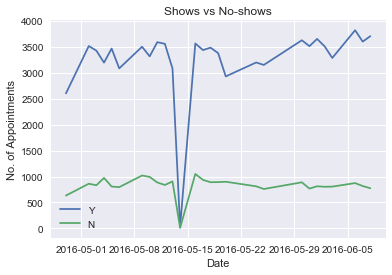

In [3]:
# Creating a crosstab that highlights when patients did and did not turn up
my_tab = pd.crosstab(index=medical_data["AppointmentDay"],  # Make a crosstab
                              columns=medical_data["No-show"])      # Name the count column
#print(my_tab.head(5))

#Plotting the previous crosstab. We add xlabels and ylabels as well as a legend and title
plt.plot(my_tab)
plt.xlabel('Date')
plt.ylabel('No. of Appointments')
plt.legend('YN')
plt.title('Shows vs No-shows')
plt.show()



As we can see in the above diagram, there is a fairly consistent pattern in booking numbers over the course of our period. There is a sharp drop, and upon investigation, was discovered to be a Saturday. These bookings were probably taken by mistake, with people not realising they were Saturday's at the time of booking.

#### Average number of appointments made at different times throughout the day
In the next block of code we will generate a graph that shows when during the day the most number of bookings was made.

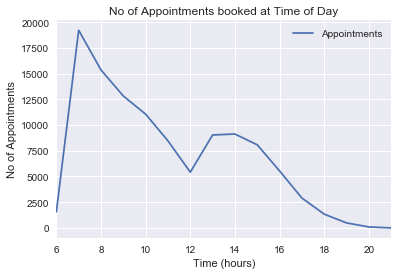

In [4]:
# Creating a graph that shows us the number of appointments booked each hour
# Creating a variable to store the date time
schedule_value=medical_data.loc[:,'ScheduledDay'].values
schedule_df=pd.DataFrame(schedule_value)
schedule_df.columns=['Date']
schedule_df['Appointments']=1

# Creating graph that sums the number of rows in each hour block of the day and returns the result
schedule_df=pd.DataFrame(schedule_df,columns=['Date','Appointments']).set_index('Date')


ax=schedule_df.groupby(schedule_df.index.hour).sum().plot()
ax.set_xlabel('Time (hours)')
ax.set_ylabel('No of Appointments')
ax.set_title('No of Appointments booked at Time of Day')


Notice, we have a large number of appointments made around 8am in the morning. This makes sense as if people were to wake up sick, the first thing they would go see the doctor in order to get medicine. We see another spike in the early afternoon, and to us, this indicates the people who either deteriated during the course of the day or if they had children, were informed by the school that their child has been sick. This leads them to book in the afternoon.


Above we examined all appointments. Next we examine what the most popular time was for booking an appointment and then the patient didn't show up is, and we expect to see a large rise again in the morning.

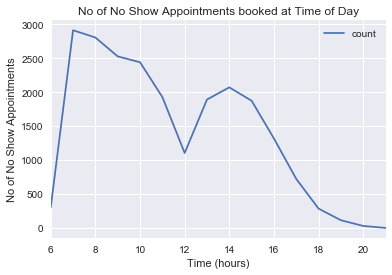

In [5]:
noShow=medical_data['No-show']=='Yes'

schedule_value=medical_data.loc[:,'ScheduledDay'][noShow].values
schedule_df=pd.DataFrame(schedule_value)
schedule_df.columns=['Date']
schedule_df['count']=1

schedule_df=pd.DataFrame(schedule_df,columns=['Date','count']).set_index('Date')


ax=schedule_df.groupby(schedule_df.index.hour).sum().plot()
ax.set_xlabel('Time (hours)')
ax.set_ylabel('No of No Show Appointments')
ax.set_title('No of No Show Appointments booked at Time of Day')


It is easy enough to see what happened here. People wake up ill, book a medical appointment, and then begin to feel better as the day progesses and opt to not go to the doctor but do not call to cancel.

As we can see, the vast majority of people make their medical appointments in the morning. Notice for the most part, the number of appointments on a given day stays the same except for the 14th May, 2016. After a brief investigation, it was discovered that this day is in fact Saturday. Moving to the second diagram, we can see that around 8am is the most popular time to book a Doctors appointment. This is probabaly due to people waking and feeling ill. Additionally, we see another rise in the early afternoon. This could be due to people deteriorating over the course of a given day. These spikes also correspond with the times the medical offices open - the initial open in the morning, and then the re-open following the lunch hour. Finally, we can see the times appointments were made, and then the patient did not turn up. As expected it shares a similar shape to our second graph. A logical reason for this shape is that patients awoke feeling ill, but as time progressed, they began to improve before deciding not to attend their appointment.

We also wanted to see if there was any trend in medical appointment no-shows for **men vs. women**. In order to look at this, we build a line graph displaying the number of show vs. no-show appointments for each gender:

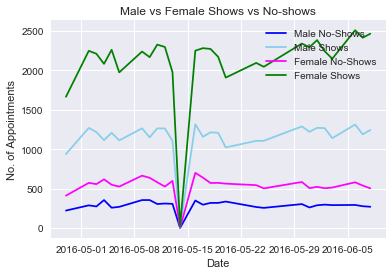

In [6]:
# Create a Crosstab For Male vs Female No-shows
noshow = medical_data.loc[medical_data['No-show'] == 'Yes']

show = medical_data.loc[medical_data['No-show'] == 'No']

male_ns = noshow.loc[noshow['Gender'] == 'M']
male_s = show.loc[show['Gender'] == 'M']

female_ns = noshow.loc[noshow['Gender'] == 'F']
female_s = show.loc[show['Gender'] == 'F']



female_noshow = pd.crosstab(index=female_ns['AppointmentDay'],  # Make a crosstab
                              columns=female_ns['No-show'])      # Name the count column

female_show = pd.crosstab(index=female_s['AppointmentDay'],  # Make a crosstab
                              columns=female_s['No-show'])      # Name the count column

male_noshow = pd.crosstab(index=male_ns['AppointmentDay'],  # Make a crosstab
                              columns=male_ns['No-show'])      # Name the count column

male_show = pd.crosstab(index=male_s['AppointmentDay'],  # Make a crosstab
                              columns=male_s['No-show'])      # Name the count column

#Plotting the previous crosstabs. We add xlabels and ylabels as well as a legend and title
plt.plot(male_noshow,label = "Male No-Shows", color = 'blue')
plt.plot(male_show,label = "Male Shows", color = 'skyblue')
plt.plot(female_noshow,label = "Female No-Shows", color = 'magenta')
plt.plot(female_show,label = "Female Shows", color = 'green')
plt.xlabel('Date')
plt.ylabel('No. of Appointments')
plt.legend(loc='upper right')
plt.title('Male vs Female Shows vs No-shows')
plt.show()


While women clearly make more medical appointments than men, both are more likely to show than not. Additionally, it seems that the number of appointments for men vs. women tends to follow the same general pattern.

## Neighbourhood Analysis
Our next task was to look some views of medical apointments by neighbourhood. We first started by plotting the count of appointments by neighbourhood in a bar chart:

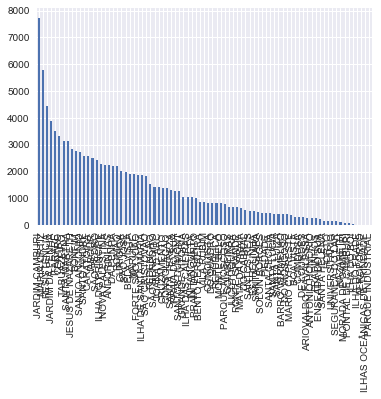

In [7]:
#plotting appointment count by neighbourhood
medical_data['Neighbourhood'].value_counts().plot(kind='bar')
plt.show()

Given the large number of neighbourhoods and variation of min and max appointments, we decided to only display the neighbourhoods with more than 2000 appointments in the total timeframe, displayed below:

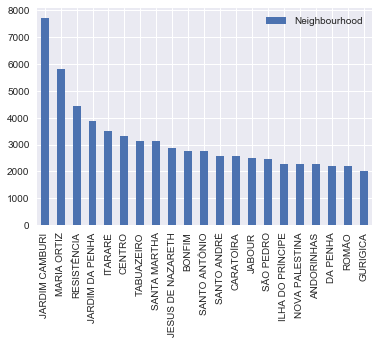

In [8]:
#replotting the appt count by neighborhood graph to only include neighbourhoods with >2000 appts
nei_val=pd.DataFrame(medical_data['Neighbourhood'].value_counts())
nei_val_fil=nei_val['Neighbourhood']>2000

nei_val[nei_val_fil].plot(kind='bar')
plt.savefig('Top_Neighbourhoods_by_Appt_Frequency.png')
plt.show()

imitting to the top neighbourhoods by number of appointments allowed for a much better visual. While the majority of the top neighbourhoods by number of appointments hover around 2-3k appointments, there are several neighbourhoods that seem to have abnormally high appointments in the timeframe. Jardim Camburi has more than double the number of appointments than the majority of other neighbourhoods.

Given the fact that Jardim Camburi is the neighbourhood with the most medical appointments, what is the show vs. no-show trend? Is the trend within the neighbourhood any different than the average trend?

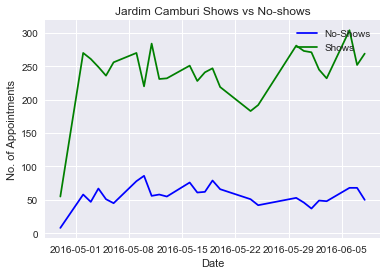

In [9]:
# Inspect the no show rate for the neighborhood with the most appointments: JARDIM CAMBURI
jardim = medical_data.loc[medical_data['Neighbourhood'] == 'JARDIM CAMBURI']

show = jardim.loc[jardim['No-show'] == 'No']
no_show = jardim.loc[jardim['No-show'] == 'Yes']



jardim_noshow = pd.crosstab(index=no_show['AppointmentDay'],  # Make a crosstab
                              columns=no_show['No-show'])      # Name the count column

jardim_show = pd.crosstab(index=show['AppointmentDay'],  # Make a crosstab
                              columns=show['No-show'])      # Name the count column


#Plotting the previous crosstabs. We add xlabels and ylabels as well as a legend and title
plt.plot(jardim_noshow,label = "No-Shows", color = 'blue')
plt.plot(jardim_show,label = "Shows", color = 'green')
plt.xlabel('Date')
plt.ylabel('No. of Appointments')
plt.legend(loc='upper right')
plt.title('Jardim Camburi Shows vs No-shows')
plt.show()

Medical appointments in Jardim Camburi drop off towards the 3rd week of May, and then spike toward the beginning of June. It also seems that the number of no-shows in this neighbourhood tends to stabalize around the 22nd of may through the end of the time frame.

Now that we understand how medical appointments vary in terms of gender and neighbourhood, let's look for any trends by medical condition.

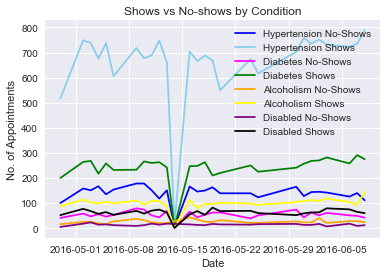

In [10]:
# Create a plot For Shows vs NoShows by Condition

noshow = medical_data.loc[medical_data['No-show'] == 'Yes']
show = medical_data.loc[medical_data['No-show'] == 'No']

hypertension_ns = noshow.loc[noshow['Hypertension'] == 1]
hypertension_s = show.loc[show['Hypertension'] == 1]
diabetes_ns = noshow.loc[noshow['Diabetes'] == 1]
diabetes_s = show.loc[show['Diabetes'] == 1]
alcoholism_ns = noshow.loc[noshow['Alcoholism'] == 1]
alcoholism_s = show.loc[show['Alcoholism'] == 1]
disabled_ns = noshow.loc[noshow['Disabled'] == 1]
disabled_s = show.loc[show['Disabled'] == 1]


hypertension_ns_ct = pd.crosstab(index=hypertension_ns['AppointmentDay'],  # Make a crosstab
                              columns=hypertension_ns['No-show'])      # Name the count column
hypertension_s_ct = pd.crosstab(index=hypertension_s['AppointmentDay'],  # Make a crosstab
                              columns=hypertension_s['No-show'])      # Name the count column
diabetes_ns_ct = pd.crosstab(index=diabetes_ns['AppointmentDay'],  # Make a crosstab
                              columns=diabetes_ns['No-show'])      # Name the count column
diabetes_s_ct = pd.crosstab(index=diabetes_s['AppointmentDay'],  # Make a crosstab
                              columns=diabetes_s['No-show'])      # Name the count column
alcoholism_ns_ct = pd.crosstab(index=alcoholism_ns['AppointmentDay'],  # Make a crosstab
                              columns=alcoholism_ns['No-show'])      # Name the count column
alcoholism_s_ct = pd.crosstab(index=alcoholism_s['AppointmentDay'],  # Make a crosstab
                              columns=alcoholism_s['No-show'])      # Name the count column
disabled_ns_ct = pd.crosstab(index=disabled_ns['AppointmentDay'],  # Make a crosstab
                              columns=disabled_ns['No-show'])      # Name the count column
disabled_s_ct = pd.crosstab(index=disabled_s['AppointmentDay'],  # Make a crosstab
                              columns=disabled_s['No-show'])      # Name the count column

#Plotting the previous crosstabs. We add xlabels and ylabels as well as a legend and title
plt.plot(hypertension_ns_ct,label = "Hypertension No-Shows", color = 'blue')
plt.plot(hypertension_s_ct,label = "Hypertension Shows", color = 'skyblue')
plt.plot(diabetes_ns_ct,label = "Diabetes No-Shows", color = 'magenta')
plt.plot(diabetes_s_ct,label = "Diabetes Shows", color = 'green')
plt.plot(alcoholism_ns_ct,label = "Alcoholism No-Shows", color = 'orange')
plt.plot(alcoholism_s_ct,label = "Alcoholism Shows", color = 'yellow')
plt.plot(disabled_ns_ct,label = "Disabled No-Shows", color = 'purple')
plt.plot(disabled_s_ct,label = "Disabled Shows", color = 'black')
plt.xlabel('Date')
plt.ylabel('No. of Appointments')
plt.legend(loc='upper right')
plt.title('Shows vs No-shows by Condition')
plt.show()

The highest appointment frequency by medical condition is hypertension, followed by diabetes. The rate of hypertension in this area seems to be very high. Individuals with alcoholism and/or are disabled are much less likely to schedule medical appointments.

Below we have some pie charts that summarize the above. We created another package to add the columns together in case we decided to do so later again.

#### Number of troopers with pre existing conditions (% of pop)

0    84115
1    18014
2     7710
3      624
4       63
5        1
Name: pre_exi_con, dtype: int64


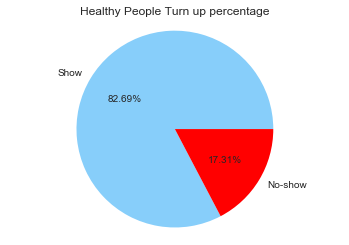

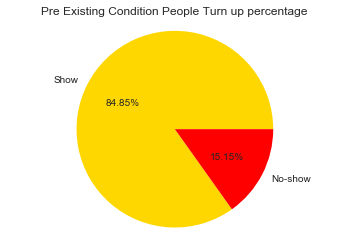

In [11]:
from col import add_columns

add_columns(medical_data,'pre_exi_con',['Diabetes','Hypertension','Alcoholism','Disabled'])

# Counts the number of occurances of 0,1,2,3 etc in our pre existing condition column and returns a table with the results
no_pec = medical_data['pre_exi_con'].value_counts()
print(no_pec)

# Storing the first row (ie our healthy people row) as a variable as a number
count_no_pec = no_pec[0]

# Storing all the people with a pre existing condition
count_pec = sum (no_pec[1:])

# Creating variable to store people with no pre existing condition and if they showed or not
no_pec_no_show  = np.count_nonzero(np.logical_and(medical_data['pre_exi_con']== 0 ,medical_data['No-show']== 'Yes'))

# Creating variable to store people with a pre existing condition and if they showed or not
pec_no_show = np.count_nonzero(np.logical_and(medical_data['pre_exi_con'] !=0 ,medical_data['No-show']== 'Yes'))

# Presenting the above as a pie chart
plt.pie([count_no_pec,no_pec_no_show],labels = ['Show','No-show'],colors=['lightskyblue','red'],autopct='%1.2f%%')
plt.axis('equal')
plt.title('Healthy People Turn up percentage')
plt.show()
plt.pie([count_pec,pec_no_show],labels = ['Show','No-show'],colors=['gold','red'],autopct='%1.2f%%')
plt.axis('equal')
plt.title('Pre Existing Condition People Turn up percentage')
plt.show()

As we can see, stormtroopers with a pre existing condition have a sightly better tendancy to turn up over individuals that do not.

#### Logistic Regression

A Logistic Regression Model (LR) is a regression model where the dependent variable (DV) is categorical. This report covers the case of a binary dependent variable—that is, where the output can take only two values, "0" and "1", which represent outcomes such as pass/fail, win/lose, alive/dead or in our case, show/no-show. The first thing we need to do is to create a deep copy of our data set as we will be transformations to the data and want to keep the integrity of the original data. The code for this portion of the report is quite extense, you can find a well documented version of it here.

First, we re coded "No-show" so it would work with a model later. Then we created a deep copy of our data as we will be doing some data transformations. Next, we created a numeric mapping for the "Neighbourhood" variable as shown below. 

In [12]:
#Creating dictionary that holds the mapping
show_mapping={'No':0,'Yes':1}
#Using the replace function to replace our strings with integers
medical_data=medical_data.replace({'No-show': show_mapping})

# Creating a deepcopy of the data so changes in this copy will not affect the original dataframe
medical_data_copy=pd.DataFrame.copy(medical_data)

regions=medical_data_copy['Neighbourhood'].unique()
print(len(regions))
numeric_val=range(0,81)
my_dict_neigh=dict(zip(regions,numeric_val))
print(my_dict_neigh)


#Using the replace function to replace our strings with integers
medical_data_copy=medical_data_copy.replace({'Neighbourhood': my_dict_neigh})

81
{'JARDIM DA PENHA': 0, 'MATA DA PRAIA': 1, 'PONTAL DE CAMBURI': 2, 'REPÚBLICA': 3, 'GOIABEIRAS': 4, 'ANDORINHAS': 5, 'CONQUISTA': 6, 'NOVA PALESTINA': 7, 'DA PENHA': 8, 'TABUAZEIRO': 9, 'BENTO FERREIRA': 10, 'SÃO PEDRO': 11, 'SANTA MARTHA': 12, 'SÃO CRISTÓVÃO': 13, 'MARUÍPE': 14, 'GRANDE VITÓRIA': 15, 'SÃO BENEDITO': 16, 'ILHA DAS CAIEIRAS': 17, 'SANTO ANDRÉ': 18, 'SOLON BORGES': 19, 'BONFIM': 20, 'JARDIM CAMBURI': 21, 'MARIA ORTIZ': 22, 'JABOUR': 23, 'ANTÔNIO HONÓRIO': 24, 'RESISTÊNCIA': 25, 'ILHA DE SANTA MARIA': 26, 'JUCUTUQUARA': 27, 'MONTE BELO': 28, 'MÁRIO CYPRESTE': 29, 'SANTO ANTÔNIO': 30, 'BELA VISTA': 31, 'PRAIA DO SUÁ': 32, 'SANTA HELENA': 33, 'ITARARÉ': 34, 'INHANGUETÁ': 35, 'UNIVERSITÁRIO': 36, 'SÃO JOSÉ': 37, 'REDENÇÃO': 38, 'SANTA CLARA': 39, 'CENTRO': 40, 'PARQUE MOSCOSO': 41, 'DO MOSCOSO': 42, 'SANTOS DUMONT': 43, 'CARATOÍRA': 44, 'ARIOVALDO FAVALESSA': 45, 'ILHA DO FRADE': 46, 'GURIGICA': 47, 'JOANA D´ARC': 48, 'CONSOLAÇÃO': 49, 'PRAIA DO CANTO': 50, 'BOA VISTA': 5

An additional variable was created for the use in the LR model. Using the "AppointmentDay" and "ScheduledDay", we calculate the difference between the two, in days, and return the result. This was done due to limitations with datetime variables. Finally we replace our "Gender" variable with our dummy gender variable.

In [13]:
# Create the difference in days variable for our table
medical_data_copy['Difference'] = medical_data_copy['AppointmentDay'].sub(medical_data_copy['ScheduledDay'], axis=0)
medical_data_copy['Difference'] = medical_data_copy['Difference'].astype(dt.timedelta).map(lambda x: np.nan if pd.isnull(x) else x.days)
medical_data_copy['Difference'] = medical_data_copy['Difference']+1

# Create a DV for Gender and Neighbourhoos
gender = pd.get_dummies(medical_data_copy['Gender'],drop_first=False)



# Remove variables that are not needed for the model
medical_data_copy.drop(['AppointmentDay','ScheduledDay','PatientId','AppointmentID','Gender'],axis=1,inplace=True)


# Combine our data with the new DV
medical_dmy = pd.concat([medical_data_copy,gender],axis=1)


We created a heatmap scaling correlation from -1 to 1 to test for multicollinearity. Multicollinearity is a phenomenon in which one predictor variable in a multiple regression model can be linearly predicted from the others with a substantial degree of accuracy.

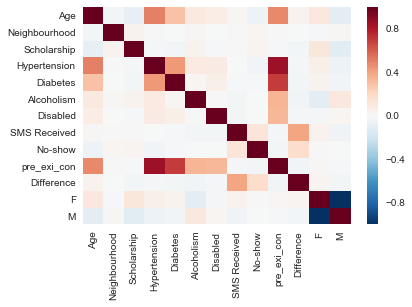

In [14]:
sb.heatmap(medical_dmy.corr())

As we can see, we have a high degree of multicollinearity with our "pre_exi_con" variable that we created earlier and the 4 existing conditions variables inheirited with the data set. Additionally, we also have a high degree of collinearity with "F" and "M" due to them being the dummy variable for "Gender" which makes sense. We exclude "M", as they can be explained by their counterpart variable, along with "SMS Received" and "Hypertension" and "Diabetes". We create our model with the following code

In [15]:
# Assigning our independent and dependent variables
X = medical_dmy.loc[:,['Neighbourhood','Age','Difference','F','Scholarship','pre_exi_con','Alcoholism','Disabled']].values
y = medical_dmy.loc[:,'No-show'].values

# Split data in train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state=25)

# Fit a logistic regression model
LogReg = LogisticRegression()
LogReg.fit(X_train, y_train)

# Predict the DV using the test set
y_pred = LogReg.predict(X_test)

from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)

# Printing our results
print(LogReg.score(X,y))
print(confusion_matrix)

print(classification_report(y_test, y_pred))

#null errror rate
y.mean()

0.794050322546
[[26258   273]
 [ 6491   137]]
             precision    recall  f1-score   support

          0       0.80      0.99      0.89     26531
          1       0.33      0.02      0.04      6628

avg / total       0.71      0.80      0.72     33159



0.20193255946510807

The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal. The formula for the F1 score is:
F1 = 2 x (precision x recall) / (precision + recall).

As we can see, with our available data, we could not create an accurate model. This did not please the Emperor. . .


![emperor](https://github.com/fairfield-university-is505-fall2017/The-Empire-Project/blob/master/Code/i-am-disappointed.jpg)